In [1]:

from qiskit.circuit.library import QFT
from qiskit.circuit import Gate, Parameter
import numpy as np
import cmath
import graycode
from qiskit import ClassicalRegister, QuantumRegister
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
import cirq_real_zgrqft_unitaries as ansatz

import matplotlib.pyplot as plt

import numpy as np
print(np.__version__)

1.26.4


In [2]:
def find_alphas(target):

    n = int(np.log(len(target))/np.log(2))

    # We first calculate alpha^{y} using
    # Eq(8) of 0407010.
    alphas_y = []

    for j in range(n):
        alpha_j = []

        for mu in range(2**(n-j-1)):

            num = 0
            for l in range(2**j):
                num = num + np.abs(target[(2*mu+1)*(2**(j))+l])**2
            num = np.sqrt(num)

            den = 0
            for l in range(2**(j+1)):
                den = den + np.abs(target[(mu)*(2**(j+1))+l])**2
            den = np.sqrt(den)

            if (den<num):
                raise ValueError("something is not right. Argument of arcsin has to be less than 1.")
            elif den==num:
                ratio = 1
            else:
                ratio = num/den

            alpha_j.append(2*np.arcsin(ratio))

        alphas_y.append(alpha_j)

    # We now calculate the alpha^{z} using
    # Eq(5) of 0407010.
    alphas_z = []
    phases = [cmath.phase(t) for t in target]

    for j in range(n):
        alpha_j = []

        for mu in range(2**(n-j-1)):

            sum = 0
            for l in range(2**j):
                sum = sum + (phases[(2*mu+1)*(2**j)+l]-phases[(2*mu)*(2**j)+l])
            sum = sum/(2**j)

            alpha_j.append(sum)

        alphas_z.append(alpha_j)

    # We now calculate the global phase
    # as defined in Eq(7) of 0407010.

    global_phase = 2*np.mean(phases)

    return alphas_y, alphas_z, global_phase

In [3]:
def find_thetas(alphas):

    # We calculate thetas using
    # Eq(3) of 0407101.

    thetas = []

    for alpha in alphas:

        theta = []

        for i in range(len(alpha)):
            theta_i = 0

            for j in range(len(alpha)):
                theta_i = theta_i + M(i,j)*alpha[j]
            theta_i = theta_i/len(alpha)

            theta.append(theta_i)

        thetas.append(theta)

    return thetas


In [4]:
def M(i,j):

    # This calculates the matrix M
    # defined in Eq(3) of 0407101.
    # However, our definition is different by a factor of 2^{-k}.

    bj = bin(j)[2:]
    bj_rev = bj[::-1]
    gi = bin(graycode.tc_to_gray_code(i))[2:]
    gi_rev = gi[::-1]

    mij = 0
    for x,y in zip(bj_rev,gi_rev):
        mij = mij + int(x)*int(y)

    return (-1)**mij

def cnot_position(r):

    g1 = bin(graycode.tc_to_gray_code(r))[2:]
    g2 = bin(graycode.tc_to_gray_code(r-1))[2:]

    if len(g2)<len(g1):
        g2 = '0' + g2

    g1_rev = g1[::-1]
    g2_rev = g2[::-1]

    for p in range(len(g1)):
        if g1_rev[p] != g2_rev[p]:
            return p+1

In [5]:
'''
Function to find the optimal parameters to represent target_function for
n ansatz qubits and m ZGR qubits
'''
def zgr_parameters(m,n,target_function):
    
    # m,n are integers
    # target_function is either a python function or a list.
    
    if type(target_function) == list:
        f = target_function
    elif type(target_function) == np.array or type(target_function) == np.ndarray:
        f = list(target_function)
    else:
        # Note since we only need first m
        # Fourier coefficients, we do not need the 
        # grid size of 2^n. Instead, we need a grid
        # of size 2^(2m). This will keep the cost constant
        # if we take n to be large.
        y = np.linspace(0,1,2**(2*m)+1) 
        f = [target_function(yi) for yi in y]
        
    print('f', f)
    fourier_coeffs = np.fft.ifft(f)
    print('FFT',fourier_coeffs)
    fourier_coeffs = fourier_coeffs[:(2**m)]
    fourier_coeffs[0] = fourier_coeffs[0]/np.sqrt(2)
    norm = np.linalg.norm(fourier_coeffs)
    
    
    alpha_y,alpha_z,global_phase = find_alphas(fourier_coeffs/norm)
    theta_y = find_thetas(alpha_y)
    theta_z = find_thetas(alpha_z)
    theta_y = theta_y[::-1]  
    theta_z = theta_z[::-1]
    flat_theta_y =  [th for th_k in theta_y for th in th_k]
    flat_theta_z =  [th for th_k in theta_z for th in th_k]
    params = [np.sqrt(2**(n+1))*norm, *flat_theta_y, *flat_theta_z, global_phase]
    
    return params

def unflatten_params(m,params):
    # input: params = [flatten theta_y, flatten theta_z, global phase]
    
    # return unlfatten_theta_y, unflatten_theta_z, global phase
    
    thetas_y = []
    thetas_y.append([params[0]])

    index = 1
    for i in range(m-1):
        thetas_y.append(params[index:index+2**(i+1)])
        index += 2**(i+1)
    thetas_y = thetas_y[::-1]

    #thetas_y goes into ZGR_Z
    thetas_z = []
    thetas_z.append([params[index]])
    index += 1

    for i in range(m-1):
        thetas_z.append(params[index:index+2**(i+1)])
        index += 2**(i+1)
    thetas_z = thetas_z[::-1]
    
    global_phase = params[-1]
    
    return thetas_y, thetas_z, global_phase

In [6]:
def UCRs(axes, thetas, n):
    
    ''' 
    This function implements the decompositon of a single uniformly
    controlled rotation in terms of rotation gates and CNOT gates.
    
    Args:
        circuit (QuantumCircuit in Qiskit): the circuit in which we 
            need to add a layer of uniformly controlled rotation.
        axes (str): axes for rotations. Either 'y' or 'z' are allowed.
        thetas (list): list of angles of rotations.
        qubits (list): list of qubits on which the uniformly controlled
            rotations are to be applied.
    
    Raises ValueError if: 
        axes other that 'y' or 'z' is chosen.
    '''
    qr = QuantumRegister(n, name ='qr')
    qc = QuantumCircuit(qr)
    
    
    if axes == 'y':
        rot = qc.ry
    elif axes == 'z':
        rot = qc.rz
    else:
        raise ValueError("Only y or z axes are allowed.")
    
    qr = list(qr)
    qr.reverse()
    
        
    r = len(thetas)-1
    if r>0:
        qc.cx(qr[-1],qr[0])
        
    rot(thetas[r], qr[0])

    rs = [(len(thetas)-2-r) for r in range(len(thetas)-1)]
    for r in rs:
        qc.cx(qr[cnot_position(r+1)], qr[0])
        rot(thetas[r], qr[0])
    ucr_gate = qc.to_gate()
    return ucr_gate

In [30]:
def CAdder(qc, n, q, inverse = False):
    ctrl = q[0]
    a = q[1:n-1]
    w = q[n-1:]

    if inverse == False:
        qc.cx(ctrl, w[n-1])
        qc.ccx(ctrl, w[n-1], w[n-2])
        qc.ccx(ctrl, w[n-1], a[0])
        qc.ccx(w[n-2], a[0], a[1])

        for i in range(n-4):
            qc.cx(a[i+1], w[n-i-3])
            qc.ccx(w[i+1], w[n-i-3], a[i+2])
        
        qc.cx(a[n-3], w[1])
        qc.ccx(a[n-3], w[1], w[0])

        for i in range(n-3):
            qc.ccx(w[i+2], a[n-i-4], a[n-i-3])

        qc.ccx(ctrl, w[n-1], a[0])
    else:
        qc.ccx(ctrl, w[n-1], a[0])
        
        for i in range(n-4, -1, -1):
            qc.ccx(q[i+2], a[n-i-4], a[n-i-3])
        qc.ccx(a[n-3], q[1], q[0])
        qc.cx(a[n-3], q[1])
        
        for i in range(n-5, -1, -1):
            qc.ccx(a[i+1], q[n-i-3], a[i+2])
            qc.cx(a[i+1], q[n-i-3])
            
        qc.ccx(q[n-2], a[0], a[1])
        qc.ccx(ctrl, q[n-1], a[0])
        qc.ccx(ctrl, q[n-1], q[n-2])
        qc.cx(ctrl, q[n-1])
        

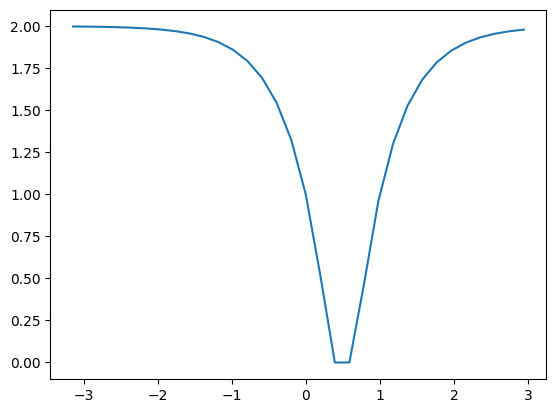

In [137]:
# # no. of qubits 
# n = 7
# # Discretizing the domain [0,1] into 2^n uniformly spaced points
# x = [k/(2**n) for k in range(2**n)]

# #Qiskit quantum state vector simulator
simulator = Aer.get_backend('statevector_simulator')


# target_f = [max(2-np.exp(1-np.abs(2*xx-1)),0) for xx in x]
# target_f = target_f/np.linalg.norm(target_f)
# #plt.plot(x,target_f)


n=5
m=3
L = 2*np.pi
x = np.linspace(-L/2, L/2, 33)
#x = np.linspace(0, L, 33)

x = list(x)
x.pop()
x = np.array(x)
#f = np.zeros(len(x))+1+0.1*np.cos(2*np.pi*x/L)
#f = np.exp(-x**2)+np.random.rand(len(x))*0.01
#f = 1/3*(2-np.sin(x))
f = [max(2-np.exp(1-np.abs(2*xx-1)),0) for xx in x]
# f = f/np.linalg.norm(f)
dt = .008
t = 2
alpha = 1
plt.plot(x, f)

In [138]:
params = zgr_parameters(m, n, f) 
print(params)
total_wires = n
m1 = int(np.log(len(params[1:])+1)/np.log(2))-1
print(m1)
m2 = total_wires - m1
thetas_y, thetas_z, phase = unflatten_params(m1,params[1:])
print(thetas_y)
print(thetas_z)
print(phase)


f [1.998132557268292, 1.9972343683506355, 1.9959041751106492, 1.993934195275759, 1.9910167089788706, 1.98669599150665, 1.980297127013383, 1.970820583576686, 1.9567860817362277, 1.9360013680665684, 1.9052197751578452, 1.8596330773058798, 1.792120423649238, 1.6921360286715008, 1.5440618722340038, 1.3247680933442232, 1.0, 0.5190273295100893, 0, 0, 0.4639661485222828, 0.9628209337788847, 1.2996636015720566, 1.52711051838906, 1.680689933694383, 1.7843916551140757, 1.854414366191781, 1.9016959349019864, 1.9336219586918546, 1.955179428607425, 1.9697357201211902, 1.9795645925938672]
FFT [ 1.58614514e+00+0.j          2.89814509e-01+0.15796839j
 -1.06930998e-01-0.16710964j  9.01797502e-03+0.11643986j
  2.93918899e-02-0.06353892j -3.45085882e-02+0.02678984j
  2.79920134e-02-0.00412361j -1.68208769e-02-0.00566982j
  8.34491172e-03+0.00862375j -1.94750426e-03-0.00697203j
 -3.38617865e-04+0.00473473j  1.60081141e-03-0.0024076j
 -9.61681580e-04+0.00134984j  1.17580870e-03-0.00071196j
 -6.40330245e-04

[0, 1, 2, 3, 4]


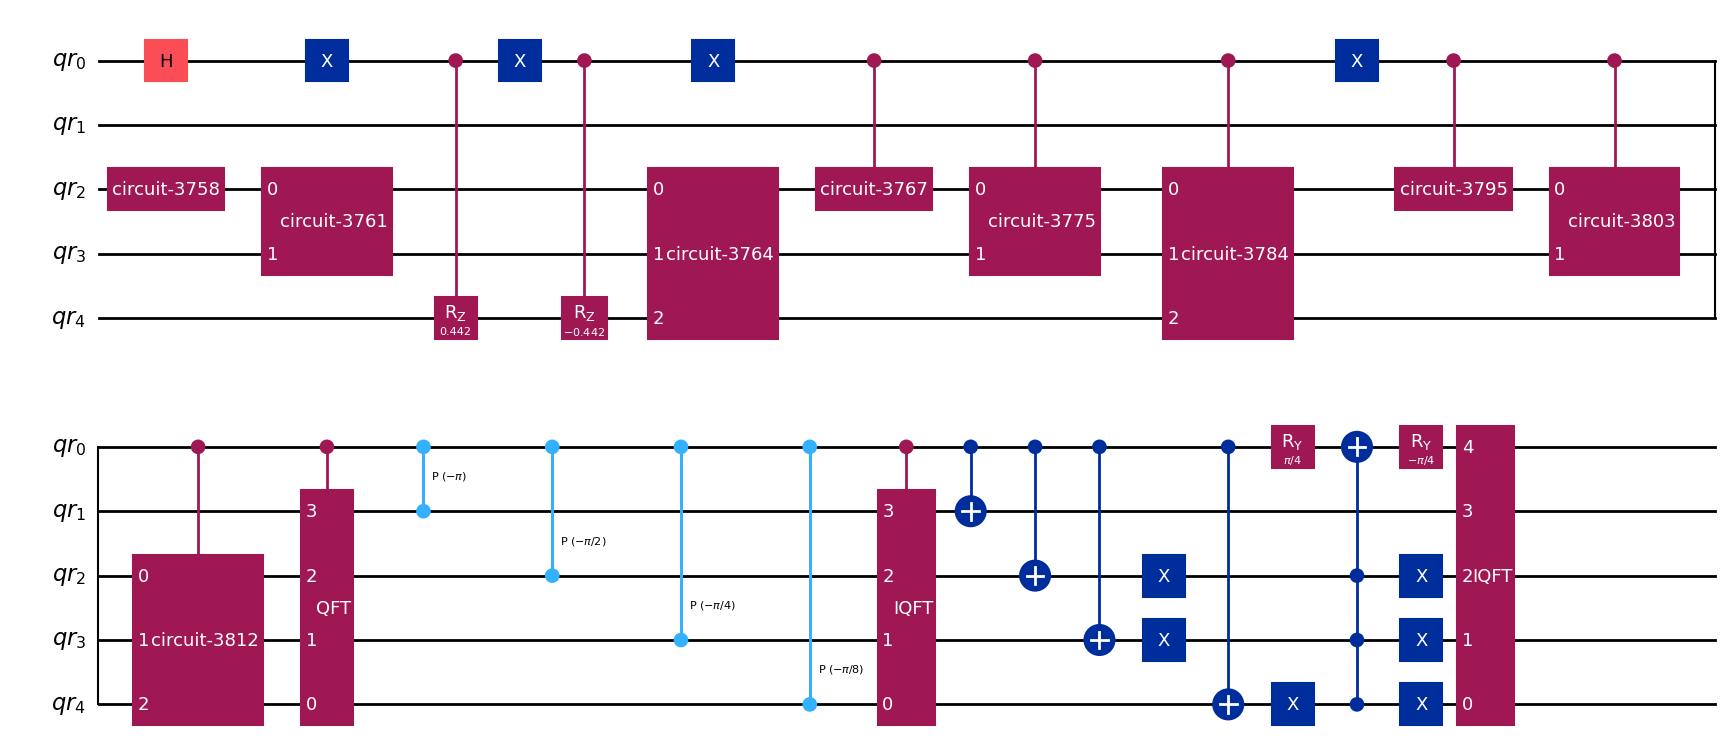

In [139]:
qr = QuantumRegister(n, name="qr")
qc = QuantumCircuit(qr)
qubits = [k for k in range(m1)]

qc.h(0)
qc.x(0)
qc.crz(-phase, 0, -1)
qc.x(0)
qc.crz(phase, 0, -1)

for w in range(m1):
    ws = [m2+j for j in range(w+1)]
    ucr1 = UCRs('y', thetas_y[m1-1-w], len(ws))
    qc.append(ucr1, ws)
    

qc.x(0)
for w in range(m1):
    ws = [m2+j for j in range(w+1)]
    ucr2 = UCRs('z', thetas_z[m1-1-w], len(ws)).control(1)
    qc.append(ucr2, [0]+ws)
    # UCRs(qc,'z',thetas_z[m1-1-w], ws, control = True)
qc.x(0)

for w in range(m1):
    ws = [m2+j for j in range(w+1)]
    # (We change the sign of theta_z)
    ucr3 = UCRs('z', [-1*thz for thz in thetas_z[m1-1-w]], len(ws)).control(1)
    qc.append(ucr3, [0]+ws)
    #UCRs(qc,'z',[-1*thz for thz in thetas_z[m1-1-w]], ws, control = True)
    
# "adder"
if m1 == 1:
    qc.cx(0,-1)
    qc.ccx(0,-1,1)
elif m1 == 2:
    qc.cx(0,-1)
    qc.ccx(0,-1,-2)
    qc.mcx([0, -1, -2], 1)
elif m1 > 2 and total_wires > 2*m1:
    wires_adder = [qr[0],*qr[2:(m1+1)],qr[1],*qr[m2:]]
    CAdder(qc,(len(wires_adder)+1)//2, wires_adder)
else:
    wires_adder = [0, 1]+[i for i in range(m2, len(qr))] 
    print(wires_adder)
    qft_gate = QFT(num_qubits=len(wires_adder)-1, do_swaps=True,approximation_degree=0).to_gate()
    controlled_qft = qft_gate.control(1)
    qc.append(controlled_qft, [wires_adder[0]]+wires_adder[:0:-1])
    for i in range(m1+1):
        phi_i = -(1/(2**i))
        qc.cp(phi_i * np.pi, wires_adder[0], wires_adder[i+1])
    qft_gate_inverse = QFT(num_qubits=len(wires_adder)-1,do_swaps=True, inverse=True,approximation_degree=0).to_gate()
    controlled_qft_inverse = qft_gate_inverse.control(1)
    qc.append(controlled_qft_inverse, [wires_adder[0]]+wires_adder[:0:-1])

# "CNOT"
qc.cx(qr[0],qr[1])
for i in range(m1):
    qc.cx(0,m2+i)
    
# "toffoli"
for i in range(2,m2):
    qc.ccx(0,1,i)

# "control Hadamard"
qc.ry(np.pi/4, 0)
for i in range(m1):
    qc.x(m2+i)
control_qubits = qr[m2:]  
target_qubit = qr[0] 
qc.mcx(control_qubits, target_qubit)
for i in range(m1):
    qc.x(qr[m2+i])
qc.ry(-np.pi/4, qr[0])


# # # # ###################
ws = [qr[i] for i in range(total_wires)]
# print(ws)
# print(len(qr))
# print(len(ws))
# qft_dagger = QFT(num_qubits=len(qr), do_swaps=True, inverse=True, approximation_degree=0).to_gate()
# qc.append(qft_dagger, qr)
qc.append(QFT(num_qubits=n, do_swaps=True, inverse=True, approximation_degree=0), range(n-1,-1,-1))
# Finally, apply the inverse QFT.
#inv_qft = QFT(num_qubits=len(ws), inverse=True)
#inv_qft = transpile(inv_qft, simulator)
# Note that Qiskit uses the opposite 
# qubit ordering. 
#qc.compose(inv_qft,qubits=range(n-1,-1,-1),inplace=True)
#qc.compose(inv_qft,qubits=ws,inplace=True)
# qct = transpile(qc, simulator)

qc.draw('mpl')


In [140]:
def output_reordering(qiskit_output):
    
    '''
    The output from the Qiskit uses a different qubit
    ordering convention from the convention that we used.
    For example, Qiskit labels the state |01000> as |2>
    and |00010> as |16>. On the other hand, our convention
    demands that |2> should be a label of |00010> and |16> 
    be a label of |01000>. 
    
    This function takes an output from the Qiskit and
    returns the output which is consistent with our
    convention.
    
    Args:
        qiskit_output (list): Output from the simulation
            performed by Qiskit. 
    '''
    
    # We first determine how many qubits there are.
    # Note: dim(qiskit_output) = 2^n
    n = int(np.round(np.log(len(qiskit_output))/np.log(2)))
    
    new_output = []
    
    for k in range(len(qiskit_output)):
        
        bin_k = bin(k)[2:]
        bin_k = (n-len(bin_k))*'0' + bin_k
        bin_k_rev = bin_k[::-1]
        k_rev = int(bin_k_rev,2)
        
        new_output.append(qiskit_output[k_rev])
    
    return new_output   

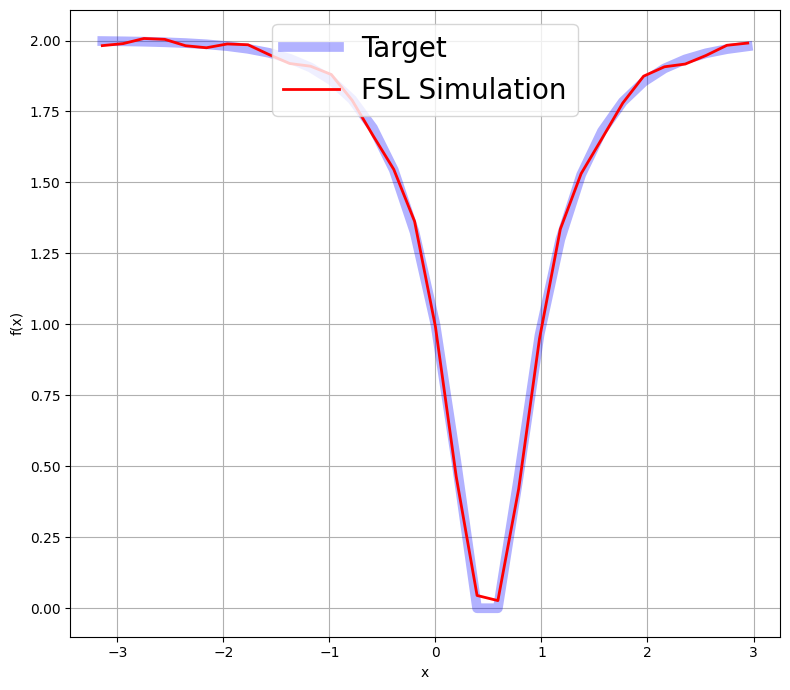

In [141]:
# qct = transpile(qc, simulator)
# job = simulator.run(qct)
# output_state = job.result().get_statevector(qct)

sim = Aer.get_backend('statevector_simulator')
result_qiskit = sim.run(transpile(qc, sim)).result()
output_state = result_qiskit.get_statevector(qc)


#simulated_f = output_reordering(output_state)

simulated_f = output_state
fig=plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
plt.grid()
line, = ax.plot(x, f, 'blue', lw=7, alpha=0.3,label='Target')
line1, = ax.plot(x, np.real(simulated_f)*params[0], 'red', lw=2,label='FSL Simulation')
#ax.plot(x,np.fft.ifft(simulated_f))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc=9,fontsize=20)
plt.tight_layout()
#plt.xlim(0.02,0.98)
#plt.ylim(-0.00001,0.002)
plt.show()